ADS Sample Notebook.

Copyright (c) 2019 Oracle, Inc. All rights reserved. Licensed under the Universal Permissive License v 1.0 as shown at https://oss.oracle.com/licenses/upl.

***
# <font color=red>Predicting Employee Attrition with ADS</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color=teal> Oracle ADS Team </font></p>

***

## Overview:

In this notebook we'll be performing exploratory data analysis to understand the data, using an employee attrition dataset. We'll then be training a model using AutoML, using it to make predictions, then evaluating how well the model generalizes to the problem. Once we're happy with the model we'll be looking into how the model works, using model-agnotic techniques the model will be picked apart and explained.

---
## Prerequisites:

  - Experience level: Novice (Python and Machine Learning)
  - Professional experience: Some industry exprience
---

## Business Use:

Organizations face huge costs resulting from employee turnover. Some costs are tangible such as training expenses and the time it takes from when an employee starts to when they become a productive member. However, the most important costs are intangible. Consider what’s lost when a productive employee quits: new product ideas, great project management, or customer relationships. With advances in machine learning and data science, it’s possible to not only predict employee attrition but to understand the key variables that influence turnover.

## Objectives:
By the end of this tutorial, you will know how to:
 - <a href='#setup'>0. Setup</a> the required packages:
 - <a href='#data'>1. Open and Vizualize Datasets</a> using ADS.
      - <a href='#data'>1.1. The Dataset</a>
      - <a href='#eda'>1.2. Exploratory Data Analysis</a> 
      - <a href='#viz'>1.3. Visualize Dataset Object</a>
      - <a href='#trans'>1.4. Get and Apply Transformation Recommendations</a> 
 - <a href='#model'>2. Building and Visualing Models</a>
      - <a href='#automl'>2.1. Build a Model Using `ADS's AutoML`</a>
      - <a href='#lr'>2.2. Build a `LogisticRegression` Model using SKLearn </a> 
 - <a href='#eval'>3. Evaluate the Models Against Eachother</a> using `ADSEvaluator`
 - <a href='#explain'>4. Explain How the Models Work</a> using `ADSExplainer`
 - <a href='#catalog'>5. Saving Models to the Model Catalog</a> using `ModelCatalog`
 - <a href='#ref'>6. References</a>
 ***
 <a id='setup'></a>

In [83]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import logging

logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

from ads.dataset.factory import DatasetFactory

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id='data'></a>
## Open and Vizualize Datasets

### The Dataset

Before we venture any further let us try to understand briefly what we mean by binary classification. Binary classification is a technique of classifying records/elements of a given dataset into two groups on the basis of classification rules for ex: Employee Attrition Prediction whether the employee is expected to Leave or Not Leave. Leave and Not Leave are the two different groups.

These classification rules are generated when we train a model using training dataset which contains information about the employees and whether the employee has left the company or not.

This is a fictional data set and contains around 1500 rows, let's load the data and take a look.


In [85]:
ds = DatasetFactory.open("data/orcl_attrition.csv", target="Attrition").set_positive_class('Yes')

In [86]:
ds.show_in_notebook()

Accordion(children=(HTML(value='<h3>Type: BinaryClassificationDataset</h3><h3>1,470 Rows, 36 Columns</h3><h4>C…

In [88]:
ds.get_recommendations()

Column 'Directs' is constant and will be dropped
Column 'Over18' is constant and will be dropped
Column 'WeeklyWorkedHours' is constant and will be dropped


Output()

<a id='eda'></a>
### Exploratory Data Analysis

In this cell we show the resulting ADS Dataset object has been profiled, types discovered, samples taken for visualization. Here we look at the `TypedFeature` for the target column.

In [3]:
ds.type_of_target()

{
  "type": "categorical",
  "low_level_type": "category",
  "missing_percentage": 0.0,
  "stats": {
    "unique percentage": 0.1360544217687075,
    "mode": false,
    "count": 1470,
    "unique": 2,
    "top": false,
    "freq": 1233
  },
  "feature_name": "Attrition"
}

In [65]:
#ds.feature_types
#ds.numeric_columns
#ds.select_best_features(k=2)


In this cell we're introduced to a function that's utilized in many places in ADS, the `show_in_notebook` function can generally be applied to any ADS object and it will make best effort to show an appropriate result. Here, when we apply the function to the target we get a plot showing the releative frequency of the classes in our data. Since the target is `Attrition` here False means people who didn't leave, while True are people that do. 

We can clearly see the dataset is imbalanced.

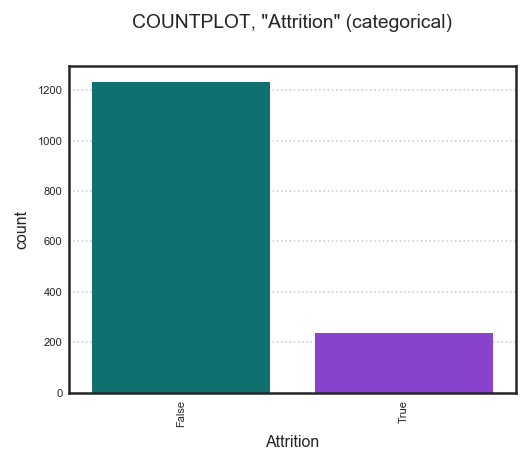

In [4]:
ds.target.show_in_notebook()

<a id='viz'></a>
### Visualize Dataset Object

Again we see the `show_in_notebook` function, this time we're applying it to the dataset itself. When we do this we get the following:

  - Summary, this shows a brief description of the dataset, shape, and some break down by feature type
  - Feature summary, a visualization created on a dataset sample to give an idea of distribution for each feature.
  - Correlations - shows how every feature (numeric and categorical)
  - Data preview (5 row `head`)


In [77]:
ds.show_in_notebook()

Accordion(children=(HTML(value='<h3>Type: BinaryClassificationDataset</h3><h3>1,470 Rows, 36 Columns</h3><h4>C…

Here we just see how we can instruct  `show_in_notebook` to open the `correlations`. You only need to pass in enough characters to uniquely identify the section.

In [66]:
ds.show_in_notebook(selected_index="corr")

Accordion(children=(HTML(value='<h3>Type: BinaryClassificationDataset</h3><h3>1,470 Rows, 36 Columns</h3><h4>C…

<a id='trans'></a>
### Get and Apply Transformation Recommendations

ADS can help transform datasets, it can, for example, fix class imbalance with up/down sampling. There are other transforms that ADS can also apply. There are two ways to do this automatically using `auto_transform()` or using the notebook UI `get_recommendations()` where you can explore the siggested transforms.

All ADS datasets are immutable, any transforms that are applied result in a new dataset.


In [68]:
transformed_ds = ds.auto_transform(fix_imbalance=False)

<a id='model'></a>
## Model Training
<a id='automl'></a>
### Oracle Labs provided AutoML

The AutoML python package automatically provide a tuned ML pipeline that best models the given a training dataset and a prediction task at hand. Here the dataset can be any supervised prediction task, e.g. classification or regression where the target can be a simple binary or a multi-class value or a real valued column in a table, respectively). The package automates three major stages of the ML pipeline: feature selection, algorithm selection, and hyperparameter optimization. 

The Oracle Labs AutoML is selected using the `OracleAutoMLProvider` object that delegates the model training to the AutoML package.

AutoML has a simple pipeline-level Python API that quickly (faster) jump-start the datascience process with a good tuned model (accurate) with appropriate features for any given prediction task.

AutoML consists three main modules Automated feature selection, model selection and hyperparameter optimization. These pieces are readily combined into a simple AutoML pipeline which automatically optimizes the whole pipeline with limited user input/interaction.

In the future additional `Providers` will be created that solve a more varied set of problems, parwise ranking, clustering, topic modeling, recommendation engines etc. You can also create your own and use them with ADS, see example notebook showing how TPOT can be used. 

ADS provides an ability to split a dataset into train and test sets.

In [90]:
from ads.automl.provider import OracleAutoMLProvider
ml_engine = OracleAutoMLProvider()

Here we see using the ADS AutoML driver to invoke the Oracle AutoML for this problem type, along with building a tuned model the `driver.AutoML` will create a baseline model. The baseline for both classification and regression problems is called the Zero Rule algorithm. Also called ZeroR. 
  - For a regression predictive modeling problem where a numeric value is predicted, the Zero Rule algorithm predicts the mean of the training dataset.
  - For a classification predictive modeling problem where a categorical value is predicted, the Zero Rule algorithm predicts the class value that has the most observations in the training dataset.
  
For any machine learning algorithm to demonstrate that it has skill on this problem, it must achieve an accuracy better than this value. The value here delivered by ADS is:

  - The importance of calculating a baseline of performance on your problem which is done for you, and you'll see in downstream cells how this baseline model performance is superimposed on the same evaluation plots.
  - How to create a baseline performance for a regression problem using the Zero Rule algorithm.
  - How to create a baseline performance for a classification problem using the Zero Rule algorithm.
  - How to create a tuned model where the AutoML provider selected the:
    - ideal feature set
    - minimal sampling size
    - best algorithm to use
    - best set of algorithm specific hyperparameters
  

In [91]:
from ads.automl.driver import AutoML
train, test = transformed_ds.train_test_split()
automl = AutoML(train, provider=ml_engine)
model, baseline = automl.train()

The `ADSModel` object wraps the actual model produced by the AutoML provider, it will delegate any attributes to the actual model so we're able to look at any of the following: 

(✓ indicates it can be visualized)

  - ranked_models_
  - num_fs_evals_
  - selected_features_names_
  - selected_model_params_
  - tuning_trials_ ✓
  - adaptive_sampling_trials_ ✓
  - feature_selection_trials_ ✓
  - model_selection_trials_ ✓

In [11]:
model.selected_model_params_

{'C': 0.06470405774008609, 'class_weight': None, 'solver': 'sag'}

In [12]:
model.ranked_models_

['LogisticRegression',
 'LinearSVC',
 'SVC',
 'AdaBoostClassifier',
 'LGBMClassifier',
 'ExtraTreesClassifier',
 'XGBClassifier',
 'RandomForestClassifier',
 'DecisionTreeClassifier',
 'KNeighborsClassifier']

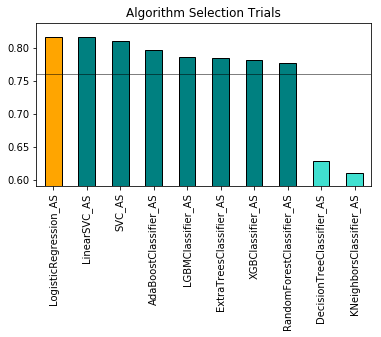

In [13]:
automl.visualize_algorithm_selection_trials()

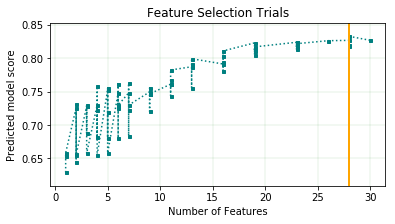

In [14]:
automl.visualize_feature_selection_trials()

In this cell we take a look at how the model training hyperprameter tuning is optimized. Over the course of the iterations through the parameter space the model gets better.

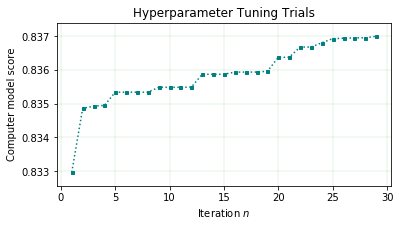

In [15]:
automl.visualize_tuning_trials()

<a id='lr'></a>
### Build a Logistic Regression model to compare with the AutoML model

We do this because we want to show how ADS is agnostic of who creates models. ADS takes advantage of duck typing, something that looks like a model and walks like a model, is, to ADS, a model. 

In [92]:
from collections import defaultdict
from ads.common.model import ADSModel
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.base import TransformerMixin
from category_encoders.ordinal import OrdinalEncoder

from sklearn.linear_model import LogisticRegression

class DataFrameLabelEncoder(TransformerMixin):
    def __init__(self):
        self.label_encoders = defaultdict(LabelEncoder)
        
    def fit(self, X):
        for column in X.columns:
            if X[column].dtype.name  in ["object", "category"]:
                self.label_encoders[column] = OrdinalEncoder()
                self.label_encoders[column].fit(X[column])
        return self
    
    def transform(self, X):
        for column, label_encoder in self.label_encoders.items():
            X[column] = label_encoder.transform(X[column])
        return X

X = train.X.copy()
y = train.y.copy()

le = DataFrameLabelEncoder()
X =le.fit_transform(X)

xgb_clf = LogisticRegression(random_state=0, solver='lbfgs')
xgb_clf.fit(X, y)

# Build an ads model from xgb classifier
my_model = ADSModel.from_estimator(make_pipeline(le, xgb_clf), name="LogisticRegression")


<a id='eval'></a>
## Evaluation

One of the key areas of ADS is the ability to evaluate models, any models. This area is under active development and will see many changes as more capabilities are added. ADS supports evaluating:

  - `regression`
  - `binary classification` 
  - `multiclass classification`
  
ADS also supports the ability for you to provide your own evaluation function (given `y_true` and `y_pred` series) for any esoteric calculation that you'd like to run on one or more models.

In the next few cells we'll see some of the examples of classification evaluation plots. For each model in the `ADSEvaluator(test, models=[ model, my_model, baseline]` line there will be a series for that metric. These are superimposed for comparison purposes. That doesn't make sense for a confusion matrix so those are shown side-by-side.

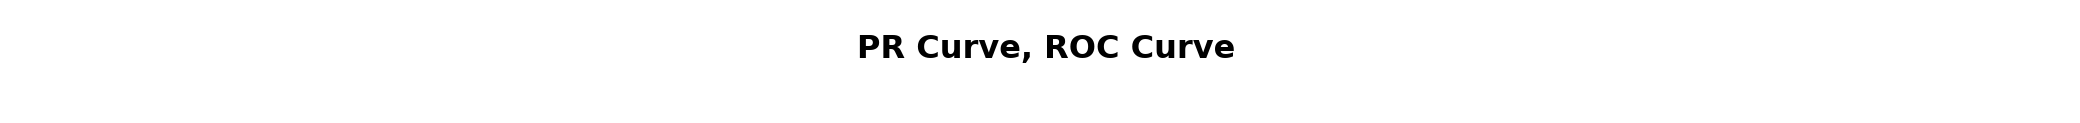

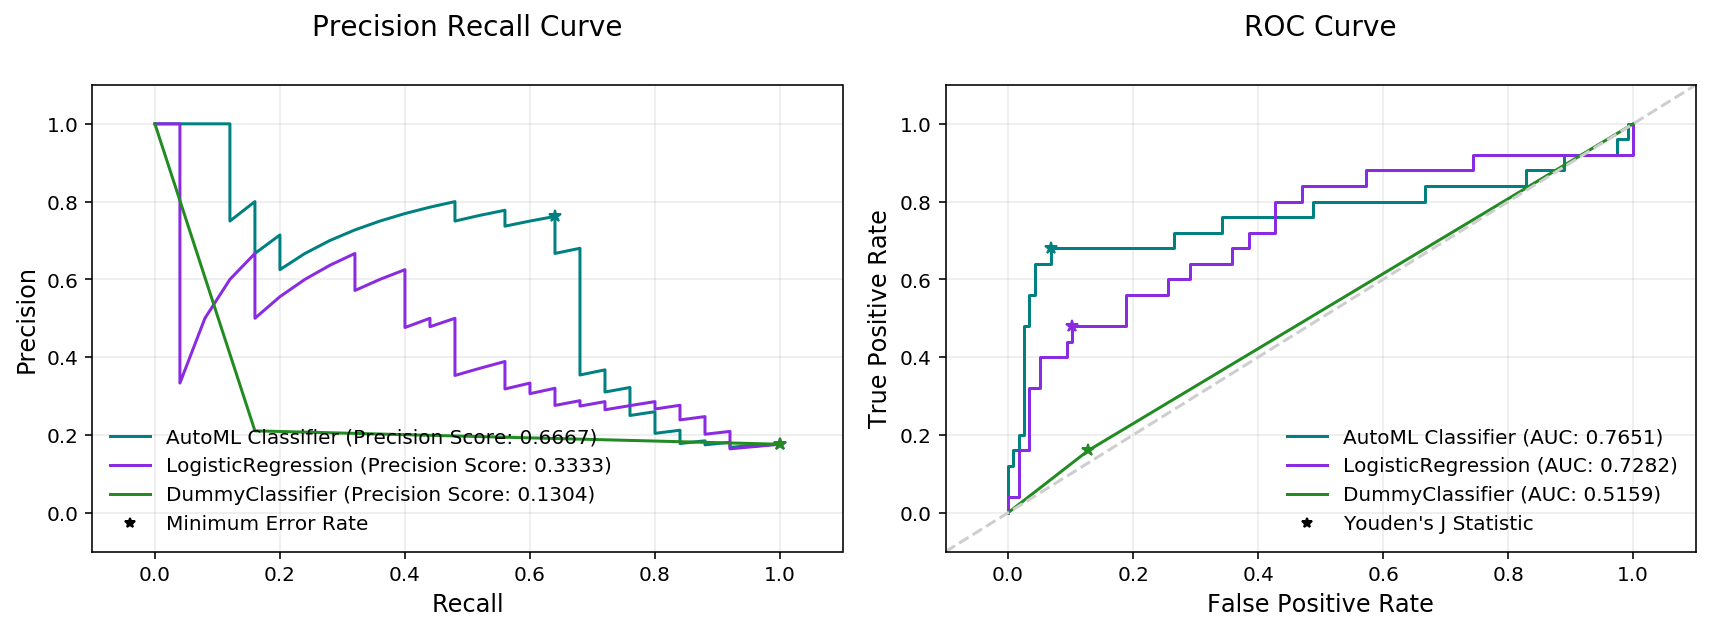

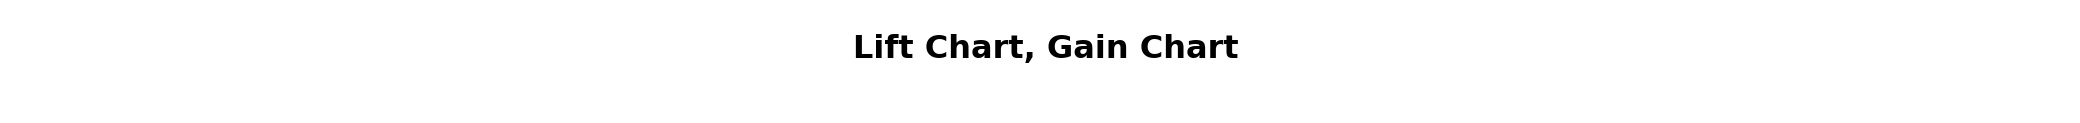

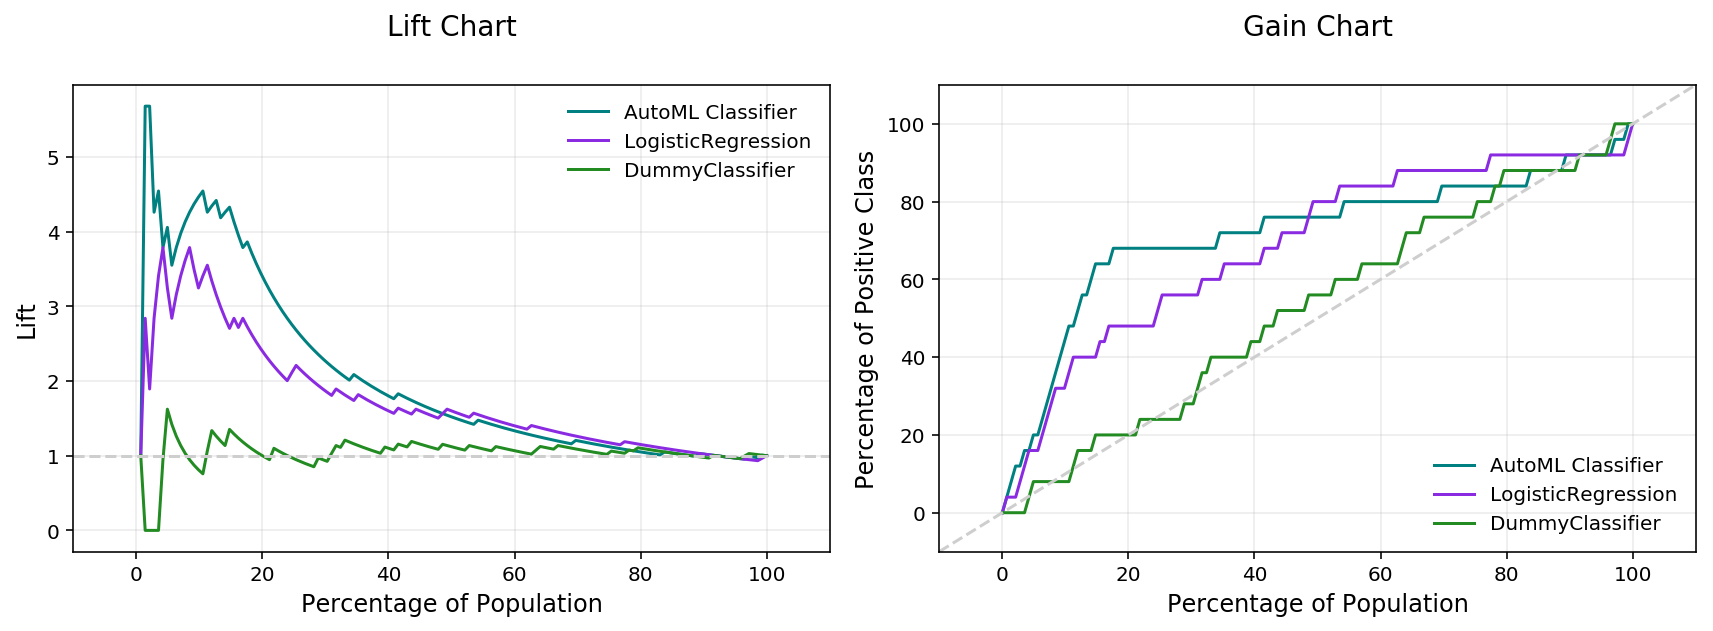

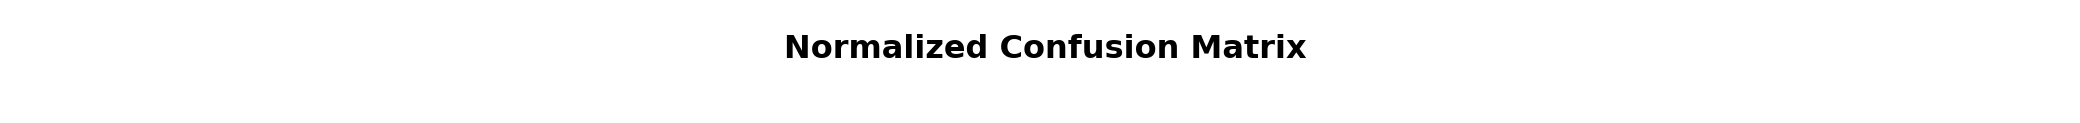

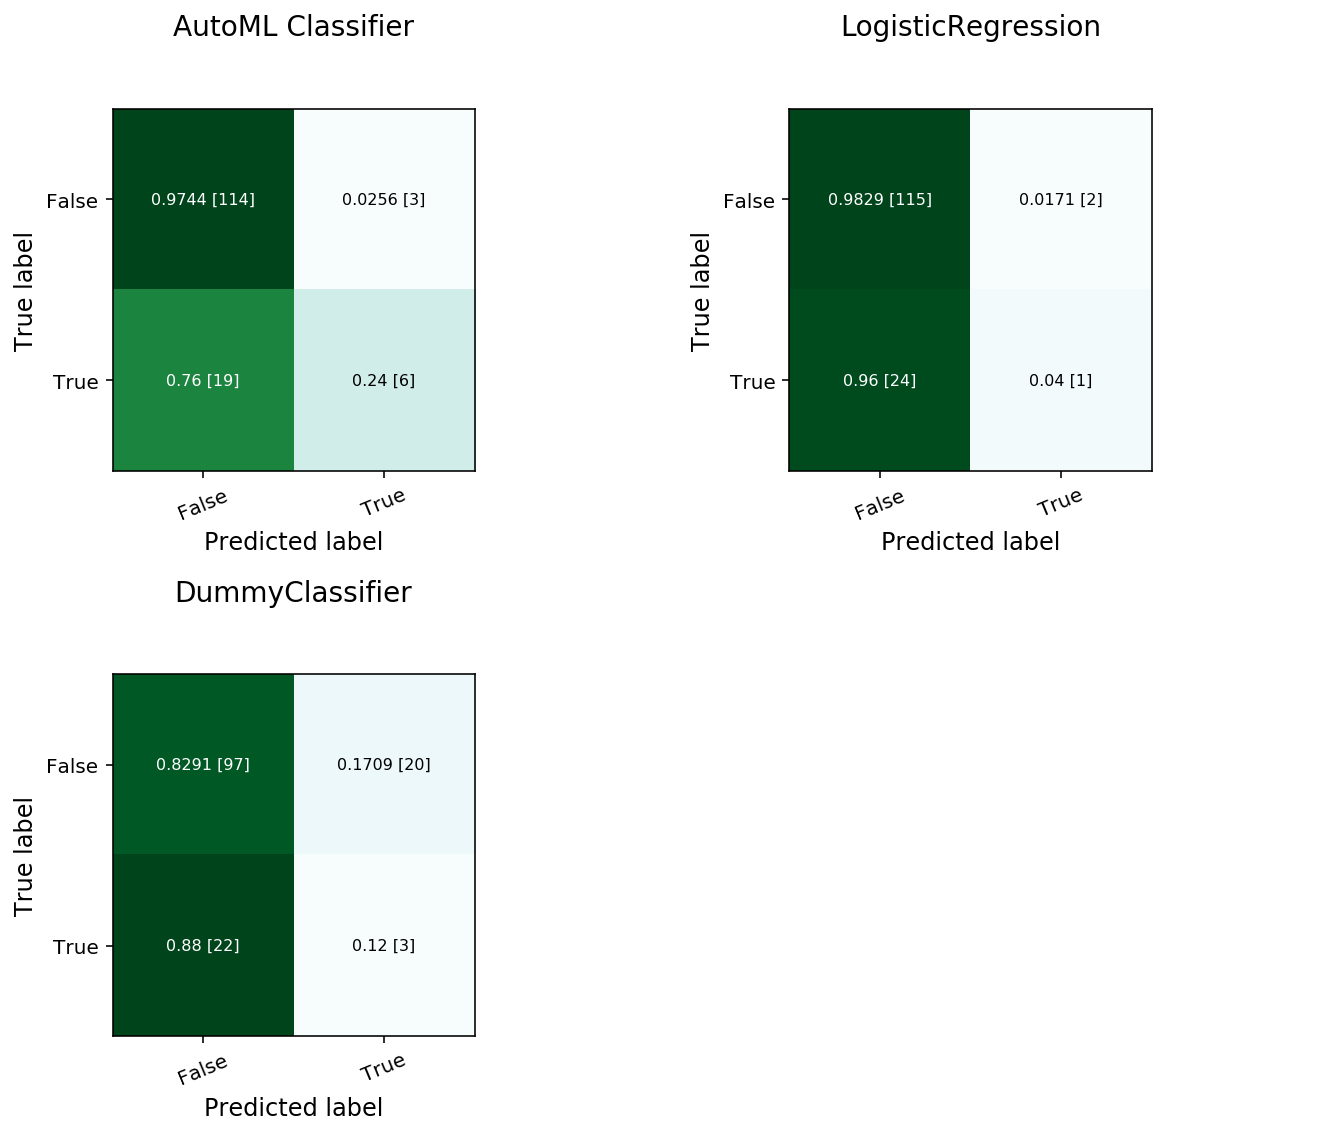

In [93]:
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import MLData

evaluator = ADSEvaluator(test, models=[ model, my_model, baseline], training_data=train)
evaluator.show_in_notebook()

In [73]:
evaluator.metrics

HTML(value='<style  type="text/css" >\n    #T_e26f2266_34b9_11ea_903b_0f6fe569eada  {\n          text-align: r…

HTML(value='<style  type="text/css" >\n    #T_e27b4de8_34b9_11ea_903b_0f6fe569eada  {\n          text-align: r…

In [20]:
evaluator.calculate_cost(tn_weight=1, fp_weight=3, fn_weight=2, tp_weight=2)

model  cost
0   AutoML Classifier   173
1  LogisticRegression   171
2     DummyClassifier   207

<a id='explain'></a>
## Model Explanations

Machine learning and deep learning are becoming ubiquitous due to:  

  - The ability to solve complex problems in a variety of different domains.
  - The growth in the performance and efficiency of modern computing resources.
  - The widespread availability of large amounts of data.
    
However, as the size and complexity of problems continue to increase, so too does the complexity of the machine learning algorithms applied to these problems. The inherent and growing complexity of machine learning algorithms limits the ability to understand what the model has learned or why a given prediction was made, acting as a barrier to the adoption of machine learning.

Machine learning explainability (MLX) is the process of explaining and interpreting machine learning and deep learning models.  

MLX can help machine learning developers to:   
  - Better understand and interpret the model's behavior.
    - E.g., Which features does the model consider important? What is the relationship between the feature values and the target predictions? 
  - Debug and improve the quality of the model. 
    - E.g., Did the model learn something unexpected? Does the model generalize or did it learn something specific to the train/validation/test datasets?
  - Increase confidence in deploying the model. 
  
MLX can help end users of machine learning algorithms to:   
  - Understand why the model made a certain prediction.
    - E.g., Why was my bank loan denied? 
   

Some useful terms for MLX:
  - **Explainability**: The ability to explain the reasons behind an machine learning model’s prediction.
  - **Interpretability**: The level at which a human can understand the explanation.
  - **Global Explanations**: Understand the behavior of an machine learning model as a whole.
  - **local Explanations**: Understand why the machine learning model made a single prediction.
  - **Model-Agnostic Explanations**: Explanations treat the machine learning model (and feature pre-processing) as a black-box, instead of using properties from the model to guide the explanation.

MLX provides interpretable model-agnostic local/global explanations.

---

## Feature permutation importance

Feature permutation importance is a model-agnostic global explanation method that provides insights into a machine learning model's behavior. It estimates and ranks feature importance based on the impact each feature has on the trained machine learning model's predictions. 

### Description of the algorithm

Feature permutation importance measures feature importance for any black-box estimator, classifier or regressor, by evaluating how the prediction error increases when a feature is not available. Any scoring metric can be used to measure the prediction error (e.g. $F1$ for classification and $R^2$ for regression). To avoid actually removing features and hence retraining the estimator, for each feature, the algorithm randomly shuffles the feature values, effectively adding noise to the feature. Then, the prediction error of the new dataset is compared with the prediction error of the original dataset. If the model heavily relies on the column being shuffled to accurately predict the target variable (an important feature), this random re-ordering will cause less accurate predictions. If the model does not rely on the feature for its predictions (an unimportant feature), the prediction error remains unchanged.

The following summarizes the main steps in computing feature permutation importance explanations:

- Start with a trained machine learning model to explain. 
- Calculate the baseline prediction error on the given dataset (e.g., train dataset or test dataset).
- For each feature:
    1. Randomly shuffle the feature column in the given dataset.
    2. Calculate the prediction error on the shuffled dataset.
    3. Store the difference between the baseline score and the shuffled dataset score as the feature importance (i.e., $baseline$\_$score$ - $shuffled$\_$score$).
- Repeat steps 1-3 multiple times and report the average to mitigate the effects of random shuffling.
- Rank the features based on the average impact each feature has on the model's score. Features that have a larger impact on the score when shuffled are assigned higher importance than features with little-to-no impact on the model's score. 
- Note that in some cases, randomly permuting an unimportant feature can actually have a positive effect on the model's prediction. In such cases, the feature's contribution towards the model's predictions is effectively noise. In the feature permutation importance visualizations, MLX caps any negative feature importance values at zero. 

### Interpreting the output

Feature permutation importance explanations generate an ordered list of features along with their importance values. Interpreting the output of this algorithm is straightforward. Features located at higher ranks have more impact on the model predictions, features at lower ranks have less impact on the model predictions. Additionally, the importance values represent the relative importance of features.

The output supports two types of visualizations: 
  - Horizontal bar chart ("bar"): The bar chart shows the model's view of the relative feature importance. The x-axis highlights feature importance. A longer bar indicates higher importance than a shorter bar. Each bar also shows the average feature importance value along with the standard deviation of importance values across all iterations of the algorithm (\<$mean$\_$importance$\> ± \<$standard$\_$deviation$\>). As described above, negative importance values are capped at zero. The y-axis shows the different features in the relative importance order (top being the most important, bottom being the least important). 
  - Detailed scatter plot ("detailed"): The detailed bar chart shows the feature importance values for each iteration of the algorithm. These values are used to compute the average feature importance values and the corresponding standard deviations shown in the bar chart. The x-axis shows the impact that permuting a given feature had on the model's prediction score. The y-axis shows the different features in the relative importance order (top being the most important, bottom being the least important). The color of each dot in the graph indicates the quality of the permutation for this iteration, which is computed by measuring the correlation of the permuted feature column relative to the original feature column (i.e., how different is the permuted feature column versus the original feature column). 

---

In [94]:
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer

# our model explainer class
explainer = ADSExplainer(test, model)

# let's created a global explainer
global_explainer = explainer.global_explanation(provider=MLXGlobalExplainer())

In [96]:
# Generate the global feature importance explanation
importances = global_explainer.compute_feature_importance()

In [24]:
# Visualize the top 6 features as a bar chart
importances.show_in_notebook(n_features=6)

In [25]:
# Visualize a detailed scatter plot
importances.show_in_notebook(n_features=5, mode='detailed')

In [26]:
# Get the dictionary object used to generate the visualizations
importances.get_global_explanation()

[{'feature': 'OverTime',
  'attribution': 0.04211830699706648,
  'std': 0.02072063925653005,
  'flat_attributions': array([0.04625164, 0.0720891 , 0.05541071, 0.03697243, 0.05541071,
         0.02901627, 0.02205395, 0.02408723, 0.07271615, 0.00654447,
         0.02408723, 0.03697243, 0.03697243, 0.05484429, 0.01068153,
         0.07619266, 0.03211441, 0.02205395, 0.06872183, 0.05917274]),
  'flat_qualities': array([1.        , 1.        , 1.        , 0.82734404, 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 0.91465214, 0.86867256, 0.95395871, 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ])},
 {'feature': 'MonthlyIncome',
  'attribution': 0.009996374367354677,
  'std': 0.010414212787474343,
  'flat_attributions': array([ 0.02901627,  0.        ,  0.00537556,  0.00537556,  0.00537556,
          0.02901627,  0.0012287 ,  0.0169478 ,  0.0117809 , -0.00545447,
          0.02408723,  0.0117809 ,  0.    

## Show what the model has learned

When an explanation doesn't make sense, it doesn't mean the explanation is wrong, it means the model has possibly learned the wrong things. This allows MLX to be used to debug the modeling process.

### ADS Explainer for custom model

In [27]:
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer

explainer_custom_model = ADSExplainer(test, my_model)

fi = explainer_custom_model.global_explanation(provider=MLXGlobalExplainer()).compute_feature_importance()

fi.show_in_notebook(n_features=6)

## Partial Dependence Plots (PDP) and Individual Conditional Expectation (ICE) Explanations

PDP and ICE are model-agnostic global explanation methods that evaluate the relationship between feature values and target variables. 

#### Description of the algorithm

PDP and ICE highlight the marginal effect that specific features have on the predictions of a machine learning model. These explanation methods try to visualize the effect different feature values have on the model's predictions. 

The following summarizes the main steps in computing PDP or ICE explanations: 

  - Start with a trained machine learning model to explain.
  - Select a feature to explain (for example, one of the important features identified in the global feature permutation importance explanations).
  - Using the selected feature's value distribution extracted from the train dataset, MLX selects multiple different values from the feature's distribution to evaluate. The number of values to use and the range of the feature's distribution to consider are configurable. 
  - MLX then replaces every sample in the provided dataset with the same feature value from the feature distribution and computes the model inference on the augmented dataset. This process is repeated for all of the selected values from the feature's distribution. If $N$ different values are selected from the feature's distribution, this process results in $N$ different datasets, each with the selected feature having the same value for all samples in the corresponding dataset. The model inference then generates $N$ different model predictions, each with $M$ values (one for each sample in the augmented dataset). 
  - For ICE, the model predictions for each augmented sample in the provided dataset (when the selected feature's value is replaced with a value from the feature distribution) are considered separately. This results in $N$x$M$ different values. 
  - For PDP, the average model prediction is computed across all augmented provided dataset samples. This results in $N$ different values (each an average of $M$ predictions). 

The description above is an example of one-feature PDP/ICE explanations. PDP also supports two-feature explanations (ICE only supports one feature). The main steps of the algorithm are the same, however, the explanation is computed on two features instead of one. 

  - Select two features to explain. 
  - MLX computes the cross-product of values selected from the feature distributions to generate a list of different value combinations for the two selected features (e.g., Assuming we have selected $N$ values from the feature distribution for each feature: \[($X_1^1$, $X_2^1$), ($X_1^1$, $X_2^2$), ... ($X_1^N$, $X_2^{N-1}$), ($X_1^N$, $X_2^N$)\] . 
  - For each feature value combination, MLX replaces every sample in the provided set with these two feature values and computes the model inference on the augmented dataset. Again, if we have $M$ different samples in the provided dataset, this results in $N^2$ predictions from the model (each an average of $M$ predictions).

#### Interpreting the output

**PDP** 
  - One-feature
      - Continuous or discrete numerical features: Visualized as line graphs. Each line represents the average prediction from the model (across all samples in the provided dataset) when the selected feature has the given value. The x-axis shows the selected feature values and the y-axis shows the target variable (e.g., the prediction probability for classification tasks and the raw predicted values for regression tasks). 
      - Categorical features: Visualized as vertical bar charts. Each bar represents the average prediction from the model (across all samples in the provided dataset) when the selected feature has the given value. The x-axis shows the different values for the selected feature and the y-axis shows the target variable (e.g., the prediction probability for classification tasks and the raw predicted values for regression tasks). 
  - Two-feature
      - Visualized as a heat map. The x-axis and y-axis both show the selected feature values. The z-axis (heat map color) represents the average prediction from the model (across all samples in the provided dataset) when the selected features have the corresponding values. 
  
**ICE**
  - Continuous or discrete numerical features: Visualized as line graphs. While PDP shows the average prediction across all samples in the provided dataset, ICE plots every sample from the provided dataset (when the selected feature is replaced with the given value) separately. The x-axis shows the selected feature values and the y-axis shows the target variable (e.g., the prediction probability for classification tasks and the raw predicted values for regression tasks). The median value can be plotted to highlight the trend. The ICE plots can also be centered around the first prediction from the feature distribution (i.e., each prediction subtracts the predicted value from the first sample).
  - Categorical features: Visualized as violin plots. The x-axis shows the different values for the selected feature  and the y-axis shows the target variable (e.g., the prediction probability for classification tasks and the raw predicted values for regression tasks). 
   
   
Both PDP and ICE visualizations display the feature value distribution from the train dataset on the corresponding axis. For example, the one-feature line graphs, bar charts, and violin plots show the feature value distribution on the x-axis. The heat map shows the feature value distributions on the respective x-axis or y-axis. 

---

In [74]:
#fi.get_global_explanation()

In [29]:
pdp_job_level = explainer.global_explanation().compute_partial_dependence("YearsAtCurrentLevel")


In [30]:
pdp_job_level.show_in_notebook(mode="pdp", labels=[False])

In [31]:
pdp_job_level.show_in_notebook(mode="ice", centered=True, show_distribution=True, show_correlation_warning=True, show_median=False)

In [ ]:
explainer.global_explanation().compute_partial_dependence(["StockOptionLevel", "EnvironmentSatisfaction"]).show_in_notebook(show_distribution=True, 
                                                                                        show_correlation_warning=False, line_gap=1)

In [32]:
explainer.global_explanation().compute_partial_dependence(["StockOptionLevel", "EnvironmentSatisfaction"]).as_dataframe()

EnvironmentSatisfaction  StockOptionLevel  mean_False  std_False  \
0                         1                 0    0.781089   0.204977   
1                         1                 1    0.803634   0.192848   
2                         1                 2    0.824650   0.180394   
3                         1                 3    0.844113   0.167754   
4                         2                 0    0.817480   0.184775   
5                         2                 1    0.837487   0.172184   
6                         2                 2    0.855939   0.159497   
7                         2                 3    0.872850   0.146852   
8                         3                 0    0.849666   0.163934   
9                         3                 1    0.867113   0.151258   
10                        3                 2    0.883039   0.138713   
11                        3                 3    0.897490   0.126428   
12                        4                 0    0.877643   0.143074   
13                        4                 1    0.892604   0.130684   
14                        4                 2    0.906124   0.118636   
15                        4                 3    0.918272   0.107044   

    mean_True  std_True  
0    0.218911  0.204977  
1    0.196366  0.192848  
2    0.175350  0.180394  
3    0.155887  0.167754  
4    0.182520  0.184775  
5    0.162513  0.172184  
6    0.144061  0.159497  
7    0.127150  0.146852  
8    0.150334  0.163934  
9    0.132887  0.151258  
10   0.116961  0.138713  
11   0.102510  0.126428  
12   0.122357  0.143074  
13   0.107396  0.130684  
14   0.093876  0.118636  
15   0.081728  0.107044

## Local Explanations

A model-agnostic local explanation method that provides insights into why a machine learning model made a specific prediction.  

#### Description of the algorithm

Unlike global explanation methods that try to understand the model behavior as a whole, local explanations try to understand why the model made a specific prediction. While a given feature might be important for the model in general, the specific values in an individual sample may cause certain features to have a larger impact on the model's prediction than others. Furthermore, given the feature values in a specific sample, local explanations can also estimate the contribution that each feature has towards or against a predicted target variable (e.g., Does the feature increase or decrease the prediction probability of a target class? Does the feature increase or decrease the predicted regression target variable?). 

The current local explanation method supported by MLX is an enhanced version of LIME (Local Intepretable Model Explanations). MLX improves the explanation quality, performance, and interpretability over LIME. The key idea behind LIME is that while the global behavior of a machine learning model might be very complex, the local behavior might be much simpler. Here, local refers to the behavior of the model on similar samples. LIME tries to approximate the local behavior of the complex machine learning model through the use of a simple, inherently interpretable *surrogate model*. For example, a linear model. If the surrogate model is able to accurately approximate the complex model's local behavior, we can generate an explanation of the complex model from the interpretable surrogate model. For example, the magnitude and sign of the coefficients in a linear model indicate the contribution each feature has towards the target variable. 

The complex machine learning model to explain (and any feature pre-processing) is considered as a black box. As such, we refer to the model to explain as the *black-box model*. MLX currently supports classification and regression models on tabular or text-based (containing a single text-based feature) datasets. 

The following summarizes the main steps in computing a local explanation for tabular datasets:

  - Start with a trained machine learning model to explain (the *black-box model*).
  - Select a specific sample to explain ($x_{exp}$). 
  - Randomly generate a large sample space in a nearby neighborhood around $x_{exp}$. The sample space is generated based on the feature distributions from the train dataset. Each sample is then weighted based on its distance from ($x_{exp}$) to give higher weight to samples that are closer to $x_{exp}$. MLX provides several enhancements to improve the quality and locality of the sample generation and weighting methods.
  - Using the black-box model, generate a prediction for each of the randomly generated local samples. For classification tasks, compute the prediction probabilities (e.g., *predict_proba()*). For regression tasks, compute the predicted regression value (e.g., *predict()*). 
  - Then, fit a simple linear surrogate model on the predicted values from the black-box model on the local generated sample space. If the surrogate model is able to accurately match the output of the black-box model (referred to as *surrogate model fidelity*), the surrogate model can act as a proxy for explaining the local behavior of the black-box model. For classification tasks, the surrogate model is a linear regression model fit on the prediction probabilities of the black-box model. Consequently, for multinomial classification tasks, a separate surrogate model is required to explain each class. In such a case, the explanation indicates if a feature contributes towards the specified class or against the specified class (i.e., towards one of the other N classes). For regression tasks, the surrogate model is a linear regression model fit on the predicted regression values from the black-box model. 
      - There are two available techniques for fitting the surrogate model:
          1. Use the features directly. 
              - The raw (normalized) feature values are used to fit the linear surrogate model directly. This results in a normal linear model. I.e., a positive coefficient indicates that when the feature value increases, the target variable increases, and a negative coefficient indicates that when a feature value increases, the target variable decreases. Categorical features are converted to binary values. A value of one indicates that the feature in the generated sample has the same value as $x_{exp}$ and a value of zero indicates that the feature in the generated sample has a different value than $x_{exp}$. 
          2. Translate the features to an *interpretable* feature space. 
              - Continuous features are converted to categorical features by discretizing the feature values (e.g., quartiles, deciles, entropy-based). Then, all features are converted to binary values. A value of one indicates that the feature in the generated sample has the same value as $x_{exp}$ (i.e., the same categorical value or the continuous feature falls in the same bin) and a value of zero indicates that the feature in the generated sample has a different value than $x_{exp}$ (i.e., a different categorical value or the continuous feature falls in a different bin). The interpretation of the linear model here is a bit different. A positive coefficient indicates that when a feature has the same value as $x_{exp}$ (i.e., in the same bin), the feature increased the prediction output from the black-box model. Similarly, negative coefficients indicate that when a feature has the same value as $x_{exp}$, the feature decreased the prediction output from the black-box model. Note that this does not say what happens when the feature is in a bin greater or less than the same bin as $x_{exp}$, only whether the specific feature having the same value as $x_{exp}$ positively or negatively impacts the black-box model's prediction.
  - The explanation is returned as an ordered list of feature importances extracted from the coefficients of the linear surrogate model. The magnitude of the coefficients indicates the relative feature importance and the sign indicates whether the feature has a positive or negative impact on the black-box model's prediction. 

The algorithm is very similar for text-based datasets. The main difference is in the random local sample space generation. Instead of randomly generating samples based on the feature distributions, a large number of local samples are generated by randomly removing subsets of words from the text sample. Each of the randomly generated samples is converted to a binary vector based on the existence of word. For example, the original sample to explain, $x_{exp}$, contains ones for every word. If the randomly generated sample has the same word as $x_{exp}$, it is a one. If the word has been removed in the randomly generated sample, it is a zero. In this case, the linear surrogate model evaluates the behavior of the model when the word is there or not. 

Additionally, an upper bound can be set on the number of features to include in the explanation (i.e., explain the top-N most important features). If the specified number of features is less than the total number of features, a simple feature selection method is applied prior to fitting the linear surrogate model. The black-box model is still evaluated on all features, but the surrogate model is only fit on the subset of features. 

#### Interpreting the output
 
MLX provides multiple enhancements to the local visualizations from LIME. The explanation is presented as a grid containing information about the black-box model, information about the local explainer, and the actual local explanation. Each row in the grid contains two columns. This is described in more detail below. 

  - Model (first row)
      - The left column presents information about the black-box model and the model's prediction. For example, the type of the black-box model, the true label/value for the selected sample to explain, the predicted value from the black-box model, and the prediction probabilities (classification) or prediction values (regression). 
      - The right column displays the sample to explain. For tabular datasets, this is a table showing the feature names and corresponding values for this sample. For text datasets, this shows the text sample to explain. 
  - Explainer (second row)
      - The left column presents the explainer configuration parameters, such as the underlying local explanation algorithm used (e.g., LIME), the type of surrogate model (e.g., linear), the number of randomly generated local samples (e.g., 5000), whether continuous features were discretized or not (see above), etc. 
      - The right column provides a legend describing how to interpret the model explanations. This is described in more detail below. 
  - Explanation (remaining rows)
      - For classification tasks, a local explanation can be generated for each of the target labels (since the surrogate model is fit to the prediction probabilities from the black-box model). For binary classification, the explanation for one class will mirror the other. For multinomial classification, the explanations describe how each feature contributes towards or against the specified target class. If the feature contributes against the specified target class (i.e., decreases the prediction probability), it increases the prediction probability of one or more other target classes. The explanation for each target class is shown as a separate row in the *Explanation* section.  
      - The left column presents the actual local explanation. The explanation is visualized as a horizontal bar chart of feature importance values, ordered by relative feature importance. Features with larger bars (top) are more important than features with shorter bars (bottom). Positive feature importance values (to the right) indicate that the feature increases the prediction target value. Negative feature importance values (to the left) indicate that the feature decreases the prediction target value. As described above, depending on whether continuous features are discretized or not changes the interpretation of this value (i.e., whether the specific feature value indicates a positive/negative attribution, or whether an increase/decrease in the feature value indicates a positive/negative attribution). If the features are discretized, the corresponding range is included. The feature importance value is shown beside each bar. This can either be the raw coefficient taken from the linear surrogate model or can be normalized such that all importance values sum to one.  
      
      For text datasets, the explanation is visualized as a *word cloud*. Important words that have a large positive contribution towards a given prediction (i.e., increase the prediction value) are shown larger than unimporant words that have less positive impact on the target prediction. 
      - The right column presents information about the *quality* of the explanation. It is further broken down into two sections:
          1. Local Surrogate Model Fidelity
              - This section presents the fidelity of the surrogate model relative to the black-box model on the randomly generated sample space used to fit the linear surrogate model. In other words, this section evaluates how accurately the surrogate model approximates the local behavior of the complex black-box model. Multiple different regression and classification metrics are supported. For classification tasks, MLX supports both regression and classification metrics. Regression metrics are computed on the raw prediction probabilities between the surrogate model and the black-box model. For classification metrics, the prediction probabilities are converted to the corresponding target labels and are compared between the surrogate model and the black-box model. Explanations for regression tasks only support regression metrics. Supported regression metrics: ***MSE***, ***RMSE*** (default), $R^2$, ***MAPE***, ***SMAPE***, ***Two Sample Kolmogorov-Smirnov Test***, ***Pearson Correlation*** (default), and ***Spearman Correlation***. Supported classification metrics: ***F1***, ***Accuracy***, ***Recall***, and ***ROC_AUC***.
          2. Fidelity vs. Locality (Only supported for tabular datasets)
              - The local surrogate model fidelity section above evaluates the surrogate model fidelity on the single randomly generated sample space used to fit the surrogate model. This section evaluates the surrogate model fidelity on multiple different leave-out test sets at increasingly larger distances from the sample to explain. The goal here is to measure the *local fidelity* of the local surrogate model. Based on the definition, the local surrogate model should have high fidelity with the black-box model on samples close to the sample to explain and should either get worse or stay the same as we evaluate samples further away from the sample to explain. We randomly generate multiple sample spaces that are constrained within a *hypersphere* of different size radiuses around the sample to explain (computed based on the percentiles of distances from the sample to explain to all other samples in the train set). We then evaluate the fidelity of the surrogate model relative to the black-box model on each of these sample spaces. The result is presented as a line graph, with the x-axis showing the increasing distances from the sample to explain and the y-axis showing the corresponding fidelity metric at each evaluation point. Only regression metrics are supported: ***MSE***, ***RMSE*** (default), $R^2$, ***MAPE***, and ***SMAPE***. 
          3. Performance
              - Explanation time in seconds. 
              
---

In [33]:
(X, y) = test.X.iloc[0:1], test.y.iloc[0:1]
X

Age TravelForWork  SalaryLevel         JobFunction  CommuteLength  \
4   28    infrequent         2710  Software Developer              3   

  EducationalLevel EducationField  EnvironmentSatisfaction Gender  HourlyRate  \
4               L1        Medical                        1   Male          40   

   ...  RelationshipSatisfaction  StockOptionLevel YearsinIndustry  \
4  ...                         4                 1               6   

   TrainingTimesLastYear WorkLifeBalance  YearsOnJob  YearsAtCurrentLevel  \
4                      3               3           2                    2   

   YearsSinceLastPromotion YearsWithCurrManager               name  
4                        2                    2  Johnathan Burnett  

[1 rows x 30 columns]

In [ ]:
from ads.explanations.mlx_local_explainer import MLXLocalExplainer

explainer.local_explanation(provider=MLXLocalExplainer()).explain(X, y).show_in_notebook(labels=[True])

### Run prediction on original data

In [34]:
X = ds.sampled_df[4:500]
y_true = ds.sampled_df["Attrition"][4:500]
print("Accuracy", model.score(X, y_true))

Accuracy 0.8811257512713823


<a id='catalog'></a>
## Save Your Model to Your Catalog

Finally, now that we understand every part of our model, we can conclude that it will be valuable in predicting employee attrition. Rather than saving this notebook, and all of the exact environmental conditions it took to create the model within, let's simply save the model to our OCI Model Catalog. To do this, we must first prepare the model:

In [35]:
from ads.catalog.model import ModelCatalog
from ads.catalog.project import ProjectCatalog
from ads.common.model_artifact import ModelArtifact

model_artifact = model.prepare("/tmp/model/", force_overwrite=True)
model_artifact2 = baseline.prepare("/tmp/model2/", force_overwrite=True)

Generated model artifact files under '/tmp/model/'. Please update the inference script (score.py) as required.


Generated model artifact files under '/tmp/model2/'. Please update the inference script (score.py) as required.


Now that we have our model artifact prepped for storage, we can pick the cloud storage location. Select the compartment_id you wish to store in, as well as the associated project. These are saved to your environment, and can be pulled using the following:

In [ ]:
import os
compartment_id = os.environ['NB_SESSION_COMPARTMENT_OCID']
project_id = os.environ["PROJECT_COMPARTMENT_OCID"]

In [ ]:
mc_model = model_artifact.save(project_id=project_id, compartment_id=compartment_id, display_name="my_model",
                                 description="test description", training_script_path="ads_binary-classification-workflow-attrition-1.ipynb", ignore_pending_changes=True)
mc_model

<a id='ref'></a>
## References: